In [1]:
import sys
import os
from pathlib import Path

p = Path(os.path.abspath(os.getcwd()))
path = Path(p)
sys.path.insert(0, str(path.parent.absolute()) + '/sub')

from imu_processing import *
from plotting import *
import pandas as pd
import numpy as np
from machine_learning import *
from magclassification import *

cwd = str(path.parent.parent.absolute())
data_cwd = cwd + '/Data/'

model_path = cwd+"/Models/"
svm = load_model(model_path + "SVM20230312")

In [2]:
class AccessoryDetect:
    def __init__(self, data, model):
        self.data = data
        self.mag = self._dic_to_lst('mag')
        self.gyro = self._dic_to_lst('gyro')
        self.model = model
        self.res = []
    
    def _dic_to_lst(self, name):
        xyz = ['X', 'Y', 'Z']
        lst = []
        
        for i in xyz:
            lst.append(self.data[name + i].to_list())
        return lst
    
    def _ts_detect2(self, var_threshold = 3, dt = 0.01, ws = 5):
        total_length = len(self.gyro[0])
        
        
    
    def _ts_detect(self, var_threshold = 3, dt = 0.01, ws = 5):
        def check_angle(angles, threshold):
            for angle in angles:
                if abs(angle) > threshold:
                    return False

            return True
        
        def integration_gyro(start, end, dt):
            res = []
            radian_to_angle = 57.29578

            for g in self.gyro:
                angle = 0
                for t in range(end-start):
                    delta = g[start + t] * radian_to_angle * dt
                    angle = angle + delta
                res.append(angle)
            return res
        
        total_length = len(self.gyro[0])
        is_detect = False
        stable_point = 0
        ts = []

        for t in range(total_length):
            if t + ws >= total_length-1:
                break

            angles = integration_gyro(t, t + ws, dt)

            if check_angle(angles, var_threshold):
                stable_point += 1
            else:
                stable_point = 0

            if stable_point >= ws:
                if stable_point == ws:
                    for i in range(ws-1):
                        ts.append(t + i - ws + 1)
                ts.append(t)

        return ts
    
    def _gather_ts(self, max_count = 5):
        cons_times = []
        start = -1
        end = 0
        ts = self.ts

        for t in range(1, len(ts)):
            if ts[t] == ts[t-1] + 1:
                # 연속적인 경우
                if start == -1:
                    # 이제 연속적으로 시작할 경우
                    start = ts[t-1]
                    end = start

                end += 1


            if ts[t] - ts[t-1] >= max_count:
                # 연속적이였을 경우
                if end - start >= 10 and start != -1:
                    cons_times.append([start, end])
                start = -1

        if end-start >= 10 and start != -1:
            cons_times.append([start, end])

        return cons_times
    
    
    def _stable_computation(self, split_ts, var_threshold = 1.0, max_stable_count = 5, max_ws = 10):
        def check_var(mag, t, threshold = 1.0, ws = 10):
            for i in range(3):
                if np.array(mag[i][t-ws:t]).var() > threshold:
                    return False
            return True

        STABLE = 1
        NON_STABLE = 0
        stable_count = 0
        values = [[] for _ in range(3)]
        stable_values = [[] for _ in range(3)]
        times = []

        status= STABLE
        start, end = split_ts[0], split_ts[1]
        ts_start = start

        mag_data = self.mag
        gradient_datas = get_gradient(mag_data)

        for t in range(start, end):
            if check_var(mag_data, t, threshold = var_threshold):
                stable_count += 1            
            else:
                if status == STABLE and t != start and stable_count >= max_stable_count:
                    #print('End stable point ! {}'.format(t))
                    for j in range(3):
                        stable_values[j].append(np.array(values[j]).mean()) 

                    times.append([ts_start, t])

                stable_count = 0
                status = NON_STABLE
                values = [[] for _ in range(3)]

            if stable_count >= max_stable_count:
                if stable_count == max_stable_count:
                    #print('Got stable point {}'.format(t))
                    for j in range(max_stable_count-1):
                        for k in range(3):
                            values[k].append(mag_data[k][t-max_stable_count+j+1])
                    ts_start = t - max_stable_count + 1

                status = STABLE
                for j in range(3):
                    values[j].append(mag_data[j][t])

        if status == STABLE:
            #print('End stable point !!! {}'.format(t))
            for j in range(3):
                stable_values[j].append(np.array(values[j]).mean()) 
            times.append([ts_start, end])

        return stable_values, times
    
    def _computation_stable_magdata(self):
        def conversion(values):
            res = [[values[0][i], values[1][i], values[2][i]] for i in range(len(values[0]))]

            return res

        diff_magdatas = []
        stable_times = []

        for ts in self.gathered_ts:
            #mag_data = dic_to_lst(data, ['magX', 'magY', 'magZ'])
            values, times = self._stable_computation(ts)
            values = conversion(values)
            print('Part time stamp')
            print(ts)
            print('Extracted Stable magnetometer Values')
            print(values)
            print('Corresponding time stamp')
            print(times)
            print('--------------------------------------')

            diff_magdatas.append(values)
            stable_times.append(times)

        return diff_magdatas, stable_times
    
    def diff_computation(self):
        def make_single_data(data):
            '''
            input : [magx data, magy data, magz data]
            '''
            keys = ['magX', 'magY', 'magZ']
            datas = {key : [] for key in keys}

            for idx, key in enumerate(keys):
                datas[key].append(data[idx])

            print(datas)

            return pd.DataFrame(datas)
        
        def check_angle(start, end, threshold = 0.1):
            g_gyro = get_gradient(self.gyro)
                
            g_gyroX = g_gyro[0][start:end]
            g_gyroY = g_gyro[1][start:end]

            val = max([abs(max(data)) for data in [g_gyroX, g_gyroY]])
            print('Check Angular gradient: {}'.format(val))

            if val <= threshold:
                return False
            else:
                return True
               
        def check_mag(start, end, threshold = 3.0):
            g_mag = get_gradient(self.mag)
            
            g_magX = g_mag[0][start:end]
            g_magY = g_mag[1][start:end]
            g_magZ = g_mag[2][start:end]
            val = max([abs(max(data)) for data in [g_magX, g_magY, g_magZ]])

            print('Check Max Mag acc value ({}, {}): {}'.format(start, end, val))

            if val <= threshold:
                return False
            else:
                return True

        def condition(value, time):
            if len(time) == 1:
                return

            print('------computation------')

            for i in range(len(time)):
                for j in range(i + 1, len(time)):
                    start, end = time[i][1], time[j][0]
                    t1, t2 = time[i][0], time[j][1]
                    print('{}, {} -> {}, {}'.format(t1, start, end, t2))

                    if check_mag(start, end) and check_angle(start, end + 5 if end+5 < t2 else end):
                        data = [value[j][k] - value[i][k] for k in range(3)]

                        s = [0, 0, 0]

                        for i in range(3):
                            s[i] = abs(data[i])

                        if np.array(s).mean() <= 10.0:
                            print('total < threshold')
                            continue

                        tdf = make_single_data(data)
                        print(self.model.predict(tdf))
                        self.res.append(self.model.predict(tdf))
                        

        for idx in range(len(self.gathered_ts)):
            value, ts = self.stable_mag_values[idx], self.gathered_ts[idx]
            print(value)
            print(ts)
            condition(value, self.stable_times[idx])
            print('-----------------------------------------------------')
    
        
    def get_data(self):
        gyro = self._dic_to_lst('gyro')
        mag = self._dic_to_lst('mag')
        # Detect timestamp when angle is stable & gather
        self.ts = self._ts_detect()
        self.gathered_ts = self._gather_ts()
        print('Total stable angle time stamps')
        print(self.gathered_ts)
        print('-----------------------------')
        
        # Compute stable magnetometer values and ts
        self.stable_mag_values, self.stable_times = self._computation_stable_magdata()
        
        # Compute diff with condition(Angle, Mag gradients)
        self.diff_computation()
    
        return self.res

In [3]:
path = data_cwd + 'Test_nature1/'
imu_data = IMU(path)
f = imu_data[0]
print(f.path)
data = f.data

ad = AccessoryDetect(data, svm)

C:\Users\jaemi\lab_magacc/Data/Test_nature1//bandgripBlack/Imu 2023-03-29 14-41-46


In [4]:
data_result = ad.get_data()
print(data_result)

Total stable angle time stamps
[[0, 115], [272, 451], [586, 782]]
-----------------------------
Part time stamp
[0, 115]
Extracted Stable magnetometer Values
[[9.773567970947827, 14.869269843304348, 64.60258450678262]]
Corresponding time stamp
[[0, 115]]
--------------------------------------
Part time stamp
[272, 451]
Extracted Stable magnetometer Values
[[34.559165591666655, -38.24866966928571, -13.334076290714288], [4.8844644442073175, 13.49871526085366, -26.56464423219512]]
Corresponding time stamp
[[282, 324], [369, 451]]
--------------------------------------
Part time stamp
[586, 782]
Extracted Stable magnetometer Values
[[-18.757335963089886, 70.70145129061797, 52.75880179224719]]
Corresponding time stamp
[[604, 782]]
--------------------------------------
[[9.773567970947827, 14.869269843304348, 64.60258450678262]]
[0, 115]
-----------------------------------------------------
[[34.559165591666655, -38.24866966928571, -13.334076290714288], [4.8844644442073175, 13.4987152608536

C:\Users\jaemi\AppData\Local\Temp/ipykernel_25784/2818916629.py:98: RuntimeWarning: Degrees of freedom <= 0 for slice
  if np.array(mag[i][t-ws:t]).var() > threshold:
C:\Users\jaemi\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\jaemi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
import scipy.signal as signal

def plot_stable_angle(gyro, ts):
    for i, j in enumerate(['X', 'Y', 'Z']):
        plot_graph(gyro[i], title = 'gyro' + j, emp = ts) 

def plot_stable_mag(data, start, end, ts, title = 'title'):
    for i, j in enumerate(['X', 'Y', 'Z']):
        plot_graph(data[i][start:end], title = 'title', emp = ts)
        
def plot_diff_with_hpf(data, name, fs = 100, cutoff = 20, order = 5):
    b, a = signal.butter(order, cutoff/(fs/2), btype='highpass')
    values = imu_to_lst(data, name)
    
    g_values = get_gradient(values)
    
    for i, j in enumerate(['X', 'Y', 'Z']):
        plot_graph(values[i], title = name + j)
        filtered_data = signal.filtfilt(b, a, values[i])
        plot_graph(filtered_data, title = 'hpf' + name + j)
        
        plot_graph(g_values[i], title = 'g' + name + j)
        filtered_data = signal.filtfilt(b, a, g_values[i])
        plot_graph(filtered_data, title = 'hpfg' + name + j)

C:\Users\jaemi\lab_magacc/Data/Test_nature1//blackcowlabsGriptokBlack/Imu 2023-03-29 14-52-17


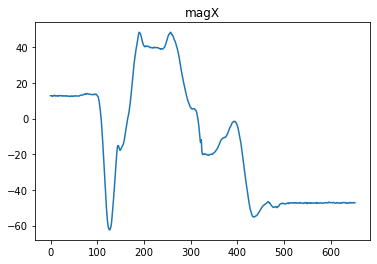

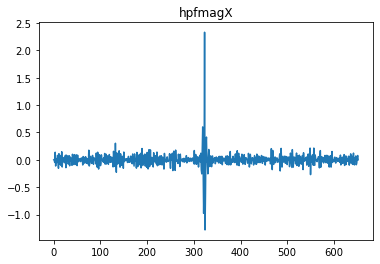

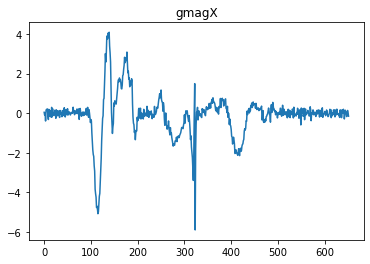

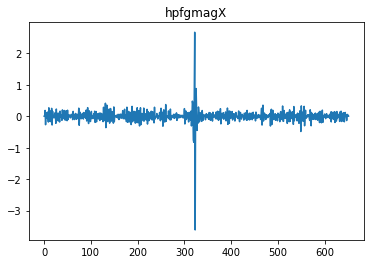

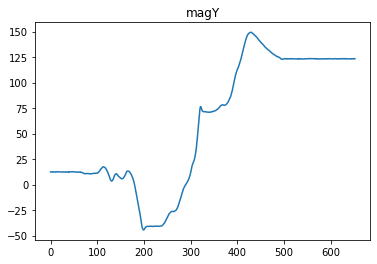

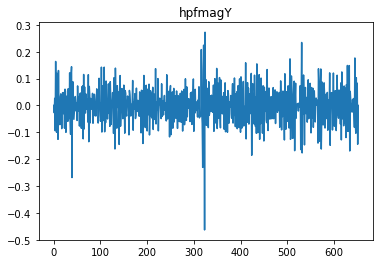

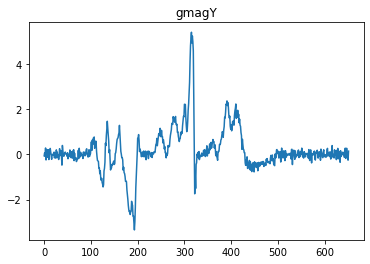

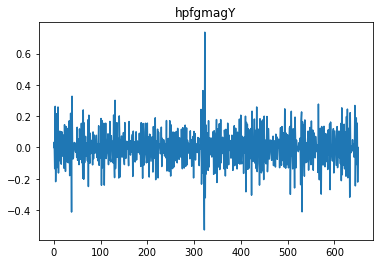

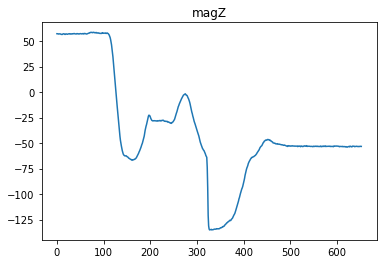

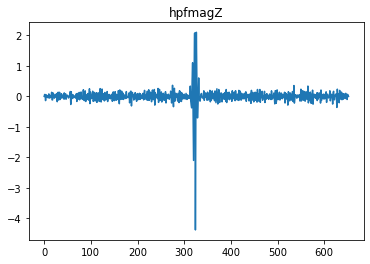

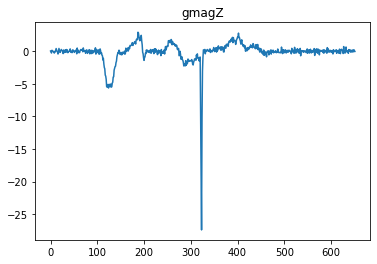

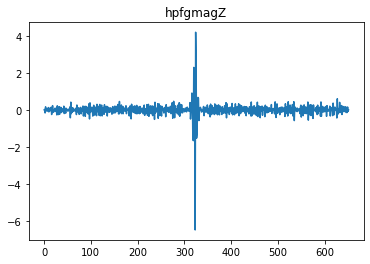

In [16]:
path = data_cwd + 'Test_nature1/'
imu_data = IMU(path)
f = imu_data[15]
print(f.path)
data = f.data

plot_diff_with_hpf(data, 'mag')

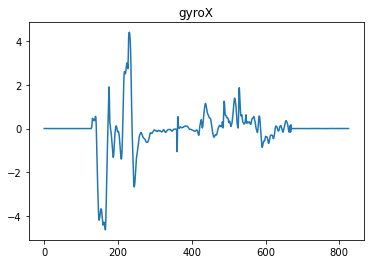

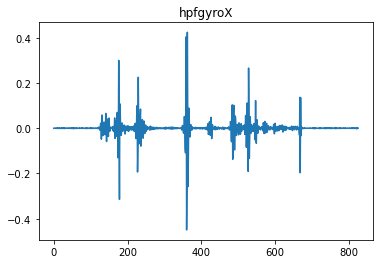

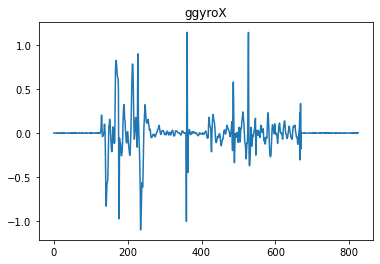

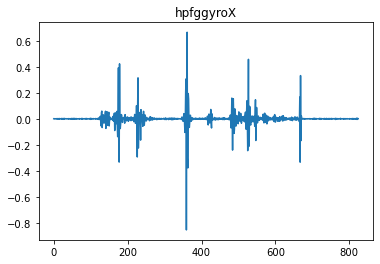

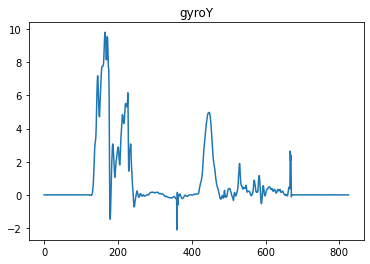

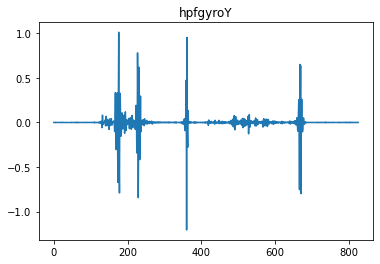

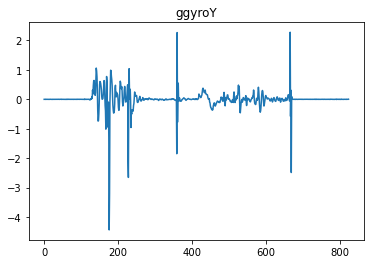

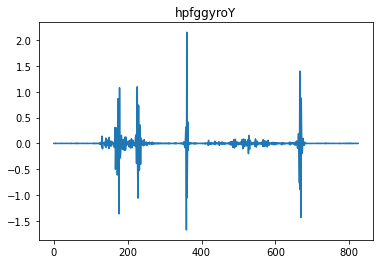

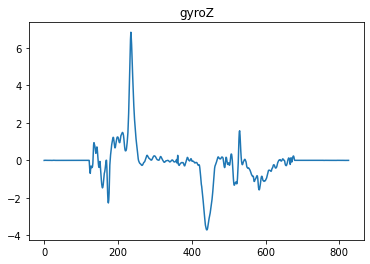

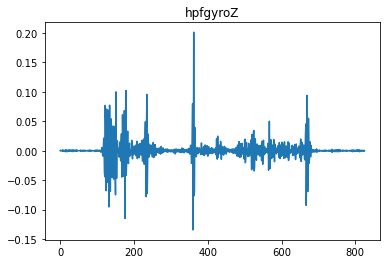

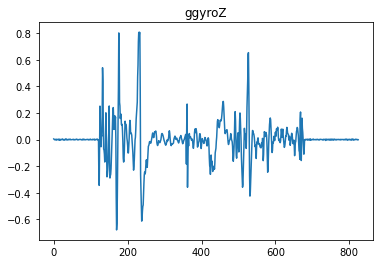

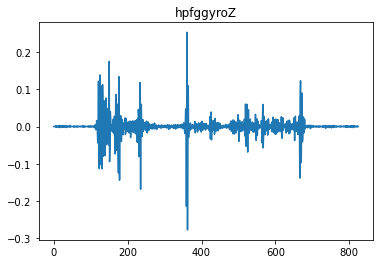

In [14]:
plot_diff_with_hpf(data, 'gyro')